In [1]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# load the Zhou et al snRNA-seq dataset
seurat_obj <- readRDS('Zhou_2020.rds')

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [10]:
source('../00_preprocessing/preprocessing.R')

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, 

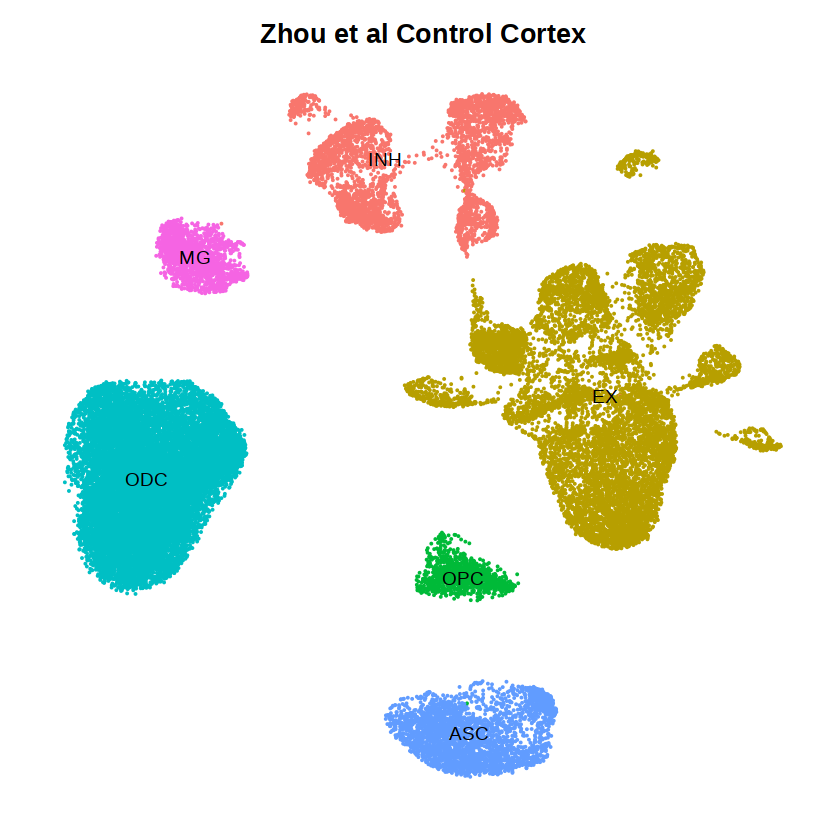

In [2]:
p <- DimPlot(seurat_obj, group.by='cell_type', label=TRUE) +
   umap_theme() + ggtitle('Zhou et al Control Cortex') + NoLegend()

p

In [13]:
plan("sequential")
seurat_obj = Seurat::SCTransform(seurat_obj,
                        assay='RNA',
                        method="glmGamPoi",
                        vst.flavor="v2",
                        verbose=TRUE) %>%
    run_sct_chaser(., resolution=0.8)

vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Total Step 1 genes: 25223

Total overdispersed genes: 24876

Excluding 347 genes from Step 1 because they are not overdispersed.

Variance stabilizing transformation of count matrix of size 28765 by 36671

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Setting estimate of  200 genes to inf as theta_mm/theta_mle < 1e-3

# of step1 poisson genes (variance < mean): 0

# of low mean genes (mean < 0.001): 3514

Total # of Step1 poisson genes (theta=Inf; variance < mean): 254

Total # of poisson genes (theta=Inf; variance < mean): 3779

Calling offset model for all 3779 poisson genes

Found 205 outliers - those will be ignored in fitting/regularization step


Ignoring theta inf genes

Replacing fit params for 3779 poisson genes by theta=Inf

Setting min_variance based on median UMI:  0.16

Second step: Get residuals using fitted parameters for 28765 genes



  |======================================================================| 100%


Computing corrected count matrix for 28765 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 6.468385 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..SCTransform.RNA; see ?make.names for more details on syntax validity"
Warning message:
"Cannot add objects with duplicate keys (offending key: PC_), setting key to 'pca_'"
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:51:59 UMAP embedding parameters a = 0.9922 b = 1.112

13:51:59 Read 36671 rows and found 30 numeric columns

13:51:59 Using Annoy for neighbor search, n_neighbors = 30

13:51:59 Building Annoy index with metric = cosine, n_tre

In [14]:
seurat_obj <- SetupForWGCNA(
  seurat_obj,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

In [16]:
# construct metacells  in each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("cell_type", "Sample"), # specify the columns in seurat_obj@meta.data to group by
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'cell_type' # set the Idents of the metacell seurat object
)

Warning message in MetacellsByGroups(seurat_obj = seurat_obj, group.by = c("cell_type", :
"Removing the following groups that did not meet min_cells: ASC#C4, MG#C2, MG#C3, MG#C4, ODC#C4, OPC#C12, OPC#C4, OPC#C9"


In [17]:
# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

In [18]:
seurat_obj

An object of class Seurat 
65366 features across 36671 samples within 2 assays 
Active assay: SCT (28765 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: harmony, umap, pca

Centering and scaling data matrix

PC_ 1 
Positive:  PLCB1, CELF2, KCNMA1, KALRN, THRB, FAM155A, MRTFB, AGBL4, CAMK1D, NRXN1 
	   NR2F1-AS1, CACNA1C, MAP2, CNKSR2, DLGAP1, NRG3, MSRA, CACNB4, CNTN1, FLRT2 
	   GABRB3, EFNA5, CDK14, BRINP1, CHL1, NRCAM, PTPRG, CADPS, PCLO, TENM2 
Negative:  PIP4K2A, DOCK5, TMEM144, FAM107B, ENPP2, TMEM165, PDE8A, NCKAP5, COL4A5, ST18 
	   SHROOM4, UGT8, PLEKHH1, C10orf90, RNF220, PXK, TF, KCNH8, FRMD4B, MBP 
	   PHLPP1, ABCA8, CLMN, ADIPOR2, PLD1, PLAAT3, MAN2A1, SLCO1A2, MOG, SIK3 
PC_ 2 
Positive:  NHSL1, CDC14A, STON2, EZR, YAP1, PLSCR4, APOE, CGNL1, FGFR3, F3 
	   ALDH1L1, NOTCH2, GLI3, FGF2, EFEMP1, MRVI1, PRDM16, NPL, OSMR-AS1, MLC1 
	   CST3, SLC1A3, GLI2, GFAP, SLC39A12, NBPF14, FAM189A2, GJA1, OSMR, STK33 
Negative:  LINC00632, ANKS1B, PTPRD, NRXN3, ANK3, CNTNAP2, AK5, APP, ATP1B1, RAPGEF5 
	   DMD, NLGN1, PDE1A, IQCJ-SCHIP1, ZNF365, KIRREL3, NKAIN2, DGKI, RYR2, DLG2 
	   PEX5L, KCNH1, KAZN, IL1RAPL1, PKP4, LRRC7, MFSD6, SLC24A2, MARCH1, ATP8A2

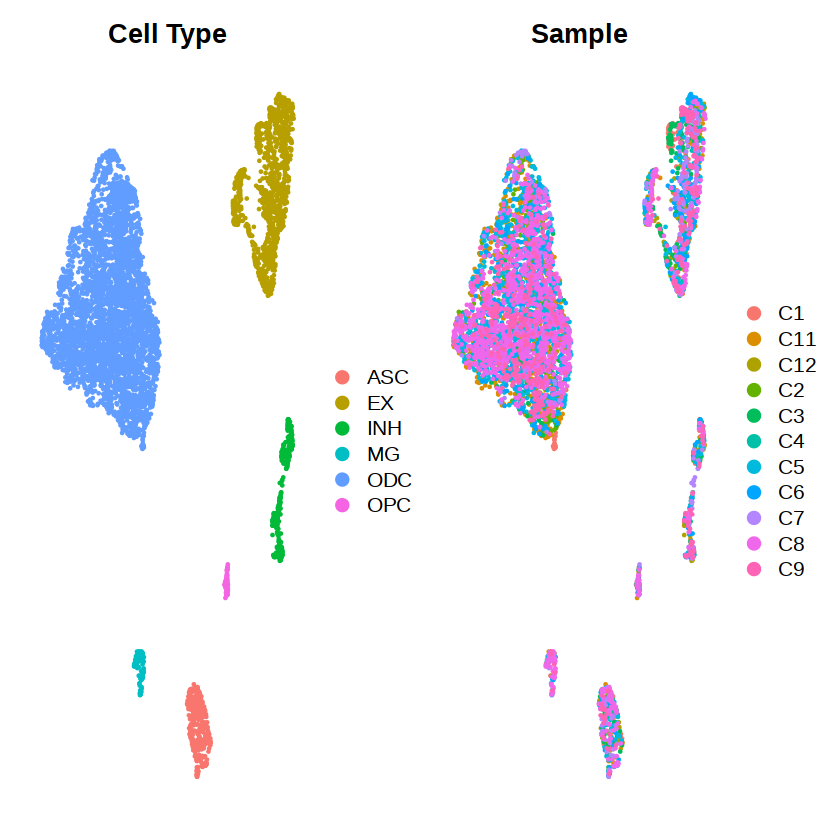

In [19]:
seurat_obj <- NormalizeMetacells(seurat_obj)
seurat_obj <- ScaleMetacells(seurat_obj, features=VariableFeatures(seurat_obj))
seurat_obj <- RunPCAMetacells(seurat_obj, features=VariableFeatures(seurat_obj))
seurat_obj <- RunHarmonyMetacells(seurat_obj, group.by.vars='Sample')
seurat_obj <- RunUMAPMetacells(seurat_obj, reduction='harmony', dims=1:15)


p1 <- DimPlotMetacells(seurat_obj, group.by='cell_type') + umap_theme() + ggtitle("Cell Type")
p2 <- DimPlotMetacells(seurat_obj, group.by='Sample') + umap_theme() + ggtitle("Sample")

p1 | p2

In [21]:
metacell_obj <- GetMetacellObject(seurat_obj)

In [22]:
metacell_obj

An object of class Seurat 
28765 features across 5754 samples within 1 assay 
Active assay: SCT (28765 features, 0 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [24]:
metacell_obj@meta.data %>% head

,orig.ident,nCount_SCT,nFeature_SCT,cells_merged,cell_type,Sample
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
ASC#C1_1,ASC#C1,5568.04,10831,"CGATGTAGTCATCGGC-11,TGACTAGAGATGTAAC-11,AGAATAGTCCAAAGTC-11,AAGACCTTCGCCATAA-11,GCTGCAGCATCCGCGA-11,AAGGAGCCACGTCAGC-11,GGCGACTGTTTGTGTG-11,CTCGTACAGAGGTTGC-11,GATGCTAAGACTGTAA-11,GCAGCCAAGACTGTAA-11,AGACGTTCATGGTCTA-11,GCGACCATCTTCATGT-11,GAGTCCGAGCCGCCTA-11,CTGCCTAAGTTACGGG-11,TAAGTGCTCAGAGACG-11,AGGCCGTTCAGCTTAG-11,GCAAACTTCATGCAAC-11,ACGCCAGCAAACTGTC-11,TGCGCAGAGAAGGTTT-11,GGACGTCCATGGAATA-11,GACACGCAGGTGCTAG-11,GTAGTCACAGGGAGAG-11,TGCTACCCATAAAGGT-11,GCGAGAACACGGCCAT-11,ACTTACTGTCTTTCAT-11",ASC,C1
ASC#C1_2,ASC#C1,5979.40,11069,"TCGAGGCGTTACGCGC-11,TTCGAAGTCGTAGATC-11,CGCGGTATCACTTCAT-11,CCGGGATAGTCTCGGC-11,GACTACACACCCATGG-11,GAGGTGACAGCGTCCA-11,ACGCAGCAGGAGCGAG-11,ATTTCTGGTTGTGGAG-11,CATGGCGAGGCAGTCA-11,GGGTCTGCACCTCGGA-11,AGCAGCCGTACCGTTA-11,GTTTCTAGTCAGTGGA-11,ACGGGTCTCCTCAACC-11,GGGAATGCAGCCAATT-11,TTCTACACACGAGAGT-11,ACATACGCACATGTGT-11,TACGGTACACCTCGGA-11,AAGACCTAGTGATCGG-11,CAGCTGGTCCGGCACA-11,CGTCACTCACAGACTT-11,ACTTACTCAGCATGAG-11,ACAGCTAAGAAGAAGC-11,ACGTCAAGTCCAGTGC-11,CGGCTAGAGTGTTAGA-11,AAAGATGAGCGTGTCC-11",ASC,C1
ASC#C1_3,ASC#C1,4604.92,9678,"GACAGAGAGCGTTGCC-11,TGACAACAGCGTTGCC-11,ATCTGCCTCCATGAGT-11,ATCTGCCTCAAACCAC-11,TCGCGTTGTATTCGTG-11,AGTCTTTCATTAACCG-11,AGACGTTTCGGCGGTT-11,ATGAGGGCATCGTCGG-11,GGACATTCATTGTGCA-11,GAACGGAAGTCCTCCT-11,CTGCCTAAGTTACGGG-11,AGAATAGCAACTGCGC-11,CTCGAAATCTGAGGGA-11,GTTCTCGTCTGTCTAT-11,TGGTTCCGTACTTAGC-11,GTAGTCACAGGGAGAG-11,CCAATCCCATCGGTTA-11,TAAGTGCTCAGAGACG-11,CGTCACTGTCACACGC-11,ACGCCAGCAAACTGTC-11,ACGATGTCACCTGGTG-11,TTCTACAGTACCTACA-11,TGGCCAGCAAGCTGAG-11,GGACGTCCATGGAATA-11,CATTCGCGTGCCTGCA-11",ASC,C1
ASC#C1_4,ASC#C1,5677.12,11021,"TGGTTCCGTACTTAGC-11,TCTCTAATCCGTTGTC-11,AGGCCGTTCAGCTTAG-11,CTCGAAATCTGAGGGA-11,ACCAGTACATCTGGTA-11,CTAGCCTTCGCATGAT-11,CGGTTAACAGACAAGC-11,CGGTTAATCGGACAAG-11,ATCTGCCTCAAACCAC-11,TGCGCAGAGAAGGTTT-11,TTGACTTTCCGCGGTA-11,TCGGGACTCAAACCAC-11,GCGAGAACACGGCCAT-11,ATCTGCCAGTAGCGGT-11,GGCGACTGTATCAGTC-11,TACTTGTAGCCTCGTG-11,GATGCTAAGCGCTTAT-11,CAAGGCCGTTACGGAG-11,GAAATGAGTGGTACAG-11,TTCTACAGTACCTACA-11,TCTCATATCTCGCTTG-11,ACGATGTCACCTGGTG-11,CACTCCAGTCAGATAA-11,TAAGTGCTCAGAGACG-11,AGAATAGTCCATGAAC-11",ASC,C1
ASC#C1_5,ASC#C1,6087.56,11414,"TGCGCAGAGAAGGTTT-11,TCTATTGAGTTGAGTA-11,TGCCAAATCAGTACGT-11,CACCAGGAGTTCGCAT-11,TGACTAGAGATGTAAC-11,CGCTGGAAGAGTCTGG-11,CTCCTAGAGATGGGTC-11,CAAGATCAGGGTCTCC-11,CTGTTTAAGGAGTAGA-11,GGCGACTGTTTGTGTG-11,ATCTGCCAGTAGCGGT-11,AAATGCCGTTTCGCTC-11,TTGGCAATCGTAGGAG-11,TCAGCTCCAATAGCAA-11,CAAGGCCGTAGCCTAT-11,GACACGCAGGTGCTAG-11,GGCGACTGTATCAGTC-11,TTCTTAGAGAAAGTGG-11,CTCCTAGCACTCTGTC-11,ATCCGAATCTCGTTTA-11,TAGTGGTAGTTGCAGG-11,TTTGTCAGTATTCTCT-11,AGCATACAGTGTTGAA-11,GAACATCGTGGCTCCA-11,GCGCAACCATTGGTAC-11",ASC,C1
ASC#C1_6,ASC#C1,6010.48,11395,"ACGCAGCAGAGACTAT-11,TTCTCAACATGGATGG-11,TCAACGAGTGAGTATA-11,ACACCCTCAGGCTGAA-11,TTTGGTTCATTTCACT-11,AGGGTGATCATCTGCC-11,CATCGAACACGGCGTT-11,CTACATTCAGCCTTGG-11,CCTTTCTCATTCTTAC-11,GATCGATTCTTCATGT-11,CACCAGGAGTTCGCAT-11,CATGGCGCAGTCTTCC-11,TGGTTCCTCGAATCCA-11,GCACTCTGTAATCGTC-11,TAAGCGTGTCGCGAAA-11,TTTGTCAGTATTCTCT-11,CATGGCGAGGCAGTCA-11,CAAGGCCGTAGCCTAT-11,TAAACCGGTCCCGACA-11,TCTTTCCGTTACGTCA-11,CTACGTCAGACTAAGT-11,GTCAAGTTCTGTACGA-11,CTCCTAGAGATGGGTC-11,TTCTTAGAGAAAGTGG-11,CGCCAAGAGAGCTGCA-11",ASC,C1


In [28]:
metacell_obj@assays$SCT@data

   [[ suppressing 32 column names 'ASC#C1_1', 'ASC#C1_2', 'ASC#C1_3' ... ]]

   [[ suppressing 32 column names 'ASC#C1_1', 'ASC#C1_2', 'ASC#C1_3' ... ]]

   [[ suppressing 32 column names 'ASC#C1_1', 'ASC#C1_2', 'ASC#C1_3' ... ]]



28765 x 5754 sparse Matrix of class "dgCMatrix"
                                                                                         
MIR1302-2HG  .          .          .          .          .          .          .         
OR4F5        .          .          .          .          .          .          .         
AL627309.1   0.25258915 0.18289559 0.08329613 0.06808684 .          0.06442954 .         
AL627309.5   .          .          .          .          .          .          .         
AP006222.2   .          .          .          .          .          .          .         
AL732372.1   .          .          .          .          .          .          .         
AC114498.1   .          .          .          .          .          .          .         
AL669831.2   .          .          .          .          .          .          .         
LINC01409    0.73120302 0.42864161 0.57760868 0.53332027 0.68592948 0.54930838 0.58148282
FAM87B       .          .          .          .     

In [30]:
WhichCells(seurat_obj, expression = LYZ < 5)

[1] "AGTCTTTGTTGATTCG-11" "AGCAGCCTCCAGATCA-11" "CTTAGGATCTCATTCA-11"
    [4] "AACTCAGAGGAATGGA-11" "ACGAGGAGTCTCCACT-11" "ACTTACTTCGGAGCAA-11"
    [7] "AATCGGTCATAAGACA-11" "CGAATGTAGGCTCAGA-11" "CGTGTAACATCCGGGT-11"
   [10] "GCTGCTTCAAAGAATC-11" "CGGAGCTCATAACCTG-11" "ACGCCGACAACACCCG-11"
   [13] "CATCGGGCATTCTTAC-11" "TGTGTTTGTTAGAACA-11" "GTATCTTTCCAGAAGG-11"
   [16] "TTTACTGAGTGAAGTT-11" "GCTGGGTGTGAAGGCT-11" "ATGCGATTCATACGGT-11"
   [19] "AGGGATGTCTCCGGTT-11" "AGCTCTCTCTGGGCCA-11" "CACTCCAGTGTTGGGA-11"
   [22] "GACGTGCGTCTAGTCA-11" "TCTTCGGCAAGACGTG-11" "ACACTGAGTCTTTCAT-11"
   [25] "AGCATACGTCATGCAT-11" "CAGCAGCTCACGATGT-11" "GTCACAACACGAGAGT-11"
   [28] "GAGTCCGCAAAGTGCG-11" "TGCGGGTCAGCTGTAT-11" "GTTCATTCATGCAACT-11"
   [31] "ACTTTCAAGGTAGCTG-11" "GCATGATAGAATGTGT-11" "ATGTGTGCACAAGTAA-11"
   [34] "GACGCGTCACACAGAG-11" "CCTAGCTGTATGGTTC-11" "GATCGTAGTTTAGGAA-11"
   [37] "AGCTCCTAGGTTACCT-11" "CGCTGGACAGCCAATT-11" "CTCTAATCAGCTTCGG-11"
   [40] "ACACTGAGTAGAGCTG-11" "CCCTCCTCAGTGGAGT-11" "CGTAGGCGTGGCCCTA-11"
   [43] "CGAGAAGGTAAGAGAG-11" "GATTCAGCACGACGAA-11" "CGAGCCATCAAGGTAA-11"
   [46] "TCACGAAAGCAGGCTA-11" "AATCGGTCATTCTCAT-11" "CATTATCCAATAGAGT-11"
   [49] "CGTGAGCAGTACCGGA-11" "GATGAGGGTAACGACG-11" "TCACGAACAATGACCT-11"
   [52] "CTCTAATGTCTAGCCG-11" "CTGCGGATCCTTTCGG-11" "ATCATGGAGAACAACT-11"
   [55] "TCGTAGAGTGTTAAGA-11" "TATCAGGCATTTCAGG-11" "CATCGGGAGACTACAA-11"
   [58] "TTCTCAAAGCCACGTC-11" "CGGAGCTCAGTCACTA-11" "GCATGATGTAGGCTGA-11"
   [61] "TTATGCTGTTAAGAAC-11" "GACGCGTCACTTGGAT-11" "CGATTGAAGAATTCCC-11"
   [64] "GTCTCGTCACAGACTT-11" "CGTTCTGCATATGGTC-11" "TCTCATACATCTCGCT-11"
   [67] "AAAGCAATCAGCTCGG-11" "ACGAGCCCAAAGGTGC-11" "CAGCATACACAGATTC-11"
   [70] "CTCCTAGTCGGCATCG-11" "ATTATCCGTTGATTCG-11" "TCGGTAAAGATGTAAC-11"
   [73] "CCACCTAGTCCAAGTT-11" "TTAGGCATCAAGAAGT-11" "TCAGATGCATTAGGCT-11"
   [76] "GTCAAGTTCTCTTGAT-11" "CAGAGAGAGGGCTTCC-11" "AGCGTATGTTAAGAAC-11"
   [79] "GTAACGTAGCGTAATA-11" "GTAACTGTCCAGATCA-11" "AACGTTGGTTTCGCTC-11"
   [82] "TCTCTAAAGGGAAACA-11" "GGGAGATCAGTGGAGT-11" "TCGCGAGAGTCATGCT-11"
   [85] "TGGCCAGGTGCAGACA-11" "GTTTCTATCACTGGGC-11" "CGCTATCGTTCCTCCA-11"
   [88] "CCCTCCTTCGTAGATC-11" "TTTATGCAGACCTTTG-11" "GCTTCCAAGCTTTGGT-11"
   [91] "TCGTAGAAGCTAACTC-11" "CAGCGACGTTCGTTGA-11" "GTGCGGTTCAAACGGG-11"
   [94] "CCGTTCATCAGGATCT-11" "CGATTGATCTTTACAC-11" "CACACTCAGAGGTTAT-11"
   [97] "GACTACATCCGCAGTG-11" "CCTACACGTACAGTGG-11" "CCTATTAGTCAATACC-11"
  [100] "GTGCAGCTCATCTGCC-11" "ACGCCAGTCGTTTAGG-11" "TGCGCAGTCTCATTCA-11"
  [103] "GGGCATCTCTGGTTCC-11" "GTGCTTCAGCTAACAA-11" "GCGCCAAGTTAAAGAC-11"
  [106] "TCAGGTAGTCGATTGT-11" "ACATCAGTCTACGAGT-11" "TGACTTTGTTTAGCTG-11"
  [109] "GATCAGTTCGGCCGAT-11" "TGTTCCGCACAACTGT-11" "CACATAGCACATCTTT-11"
  [112] "CCTACACGTCATGCAT-11" "CAACTAGCATTTCACT-11" "AGAGCGACACATCCGG-11"
  [115] "GTGTTAGCACGTGAGA-11" "TGAGAGGTCTAAGCCA-11" "CTGCCTAGTAGGCTGA-11"
  [118] "ACGGGCTTCTGCTGTC-11" "GTCCTCACAGCTCGCA-11" "TTCGAAGAGACAATAC-11"
  [121] "TCCCGATAGGATCGCA-11" "ATTCTACTCTGGCGAC-11" "AATCGGTGTTCGTTGA-11"
  [124] "GTAACTGCATGCCCGA-11" "ATTCTACGTCGACTAT-11" "TCAGCAAAGACACGAC-11"
  [127] "GTTTCTAAGAAACCTA-11" "CGGCTAGCAATCCGAT-11" "TTCTCCTGTACCATCA-11"
  [130] "GTGTTAGCAAGCCTAT-11" "TTTCCTCAGGCCCTTG-11" "CATGGCGAGCTGCGAA-11"
  [133] "TGCTACCGTCGCTTCT-11" "GACTGCGGTCCTCTTG-11" "CATCAGACACCAGCAC-11"
  [136] "CATCAAGTCCTTAATC-11" "AAACCTGAGGCGTACA-11" "TACTCGCAGTTGCAGG-11"
  [139] "AGGGAGTCATGTAAGA-11" "ATCGAGTCATCCGTGG-11" "GCACTCTTCGATAGAA-11"
  [142] "GTACTTTAGGCTCTTA-11" "GGAACTTAGTACGTAA-11" "TGCTGCTGTCCAAGTT-11"
  [145] "TCTTTCCCAGAGCCAA-11" "TGCGTGGTCCTCCTAG-11" "GGAACTTGTACTTGAC-11"
  [148] "CAGAGAGAGGCAGTCA-11" "GAGGTGACACAGCGTC-11" "ATTATCCTCACAGGCC-11"
  [151] "TTGACTTAGGCATGTG-11" "ACGGAGATCGCCTGTT-11" "GGACAGATCTATCCCG-11"
  [154] "AGGTCATCAATCGAAA-11" "GATCGCGCAACTTGAC-11" "AGATCTGTCTATCCTA-11"
  [157] "AGAGCGAAGAGCTATA-11" "TCATTACCATTTCACT-11" "TGCCAAATCAACGAAA-11"
  [160] "AGTCTTTGTACAAGTA-11" "CAGCATATCGTTTAGG-11" "GGCAATTGTTTACTCT-11"
  [163] 